# PCA test reducing 6 dimensions to 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import time

from tqdm import tqdm

import openmm
from openmm import unit
from openmm.app.topology import Topology
from openmm.app.element import Element
import mdtraj
import csv

import config
from dham import *
from util import *

#### Data simulation

I will first amend the 2 dimensional langevin simulation by adding another atom that has the same initial dummy free energy surface that the z coordinate of the first atom has. I will then produce an array with positions in every dimension and then perform PCA analysis on this data to get the first two principal components which I will then assign to the dimensions.

In [2]:
elem = Element(0, "X", "X", 1.0)
top = Topology()
top.addChain()
top.addResidue("xxx", top._chains[0])
top.addAtom("X1", elem, top._chains[0]._residues[0])
top.addAtom("X2", elem, top._chains[0]._residues[0])
mass = 12.0 * unit.amu

In [3]:
print("system initializing")
#print out all the config.
print("config: ", config.__dict__)

time_tag = time.strftime("%Y%m%d-%H%M%S")

#print current time tag.
print("time_tag: ", time_tag)

system = openmm.System() #we initialize the system every
system.addParticle(mass)
system.addParticle(mass)
#gaussian_param = np.loadtxt("./params/gaussian_fes_param.txt")
system, fes = apply_fes(system = system, particle_idx=0, gaussian_param = None, pbc = config.pbc, amp = config.amp, name = "FES", mode=config.fes_mode, plot = True)
z1_pot = openmm.CustomExternalForce("1e3 * z^2") # very large force constant in z
z1_pot.addParticle(0)
x2_pot = openmm.CustomExternalForce("1e3 * x^2")
y2_pot = openmm.CustomExternalForce("1e3 * y^2")
z2_pot = openmm.CustomExternalForce("1e3 * z^2")
z2_pot.addParticle(0)
x2_pot.addParticle(1)
y2_pot.addParticle(1)
z2_pot.addParticle(1)
system.addForce(z1_pot) #on z, large barrier
system.addForce(x2_pot)
system.addForce(y2_pot)
system.addForce(z2_pot)



#pbc section
if config.pbc:
    a = unit.Quantity((2*np.pi*unit.nanometers, 0*unit.nanometers, 0*unit.nanometers))
    b = unit.Quantity((0*unit.nanometers, 2*np.pi*unit.nanometers, 0*unit.nanometers))
    c = unit.Quantity((0*unit.nanometers, 0*unit.nanometers, 1*unit.nanometers)) # atom not moving in z so we set it to 1 nm
    system.setDefaultPeriodicBoxVectors(a,b,c)

#integrator
integrator = openmm.LangevinIntegrator(300*unit.kelvin, 
                                    1.0/unit.picoseconds, 
                                    0.002*unit.picoseconds)

num_propagation = int(config.sim_steps/config.propagation_step)
frame_per_propagation = int(config.propagation_step/config.dcdfreq_mfpt)
#this stores the digitized, ravelled, x, y coordinates of the particle, for every propagation.
pos_traj = np.zeros([num_propagation, frame_per_propagation]) #shape: [num_propagation, frame_per_propagation]


x,y = np.meshgrid(np.linspace(0, 2*np.pi, config.num_bins), np.linspace(0, 2*np.pi, config.num_bins))

#we start propagation.
#note num_propagation = config.sim_steps/config.propagation_step
reach = None
i_prop = 0
#for i_prop in range(num_propagation):

system initializing
config:  {'__name__': 'config', '__doc__': None, '__package__': '', '__loader__': <_frozen_importlib_external.SourceFileLoader object at 0x7f50a27ea4d0>, '__spec__': ModuleSpec(name='config', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7f50a27ea4d0>, origin='/home/student/George_Saba/github_repo/RL_MFPT/2D_langevin_sim/config.py'), '__file__': '/home/student/George_Saba/github_repo/RL_MFPT/2D_langevin_sim/config.py', '__cached__': '/home/student/George_Saba/github_repo/RL_MFPT/2D_langevin_sim/__pycache__/config.cpython-311.pyc', '__builtins__': {'__name__': 'builtins', '__doc__': "Built-in functions, types, exceptions, and other objects.\n\nThis module provides direct access to all 'built-in'\nidentifiers of Python; for example, builtins.len is\nthe full name for the built-in function len().\n\nThis module is not normally accessed explicitly by most\napplications, but can be useful in modules that provide\nobjects with the same name as a built-in

In [4]:
i_prop = "George"
print("propagation 0 starting")
gaussian_params = random_initial_bias_2d(initial_position = config.start_state, num_gaussians = config.num_gaussian)
np.savetxt(f"./params/{time_tag}_gaussian_fes_param_{i_prop}.txt", gaussian_params)
#we apply the initial gaussian bias (v small) to the system
system = apply_bias(system = system, particle_idx=0, gaussian_param = gaussian_params, pbc = config.pbc, name = "BIAS", num_gaussians = config.num_gaussian)

#create simulation object, this create a context object automatically.
# when we need to pass a context object, we can pass simulation instead.
simulation = openmm.app.Simulation(top, system, integrator, config.platform)
simulation.context.setPositions(config.start_state)
simulation.context.setVelocitiesToTemperature(300*unit.kelvin)

simulation.minimizeEnergy()
if config.pbc:
    simulation.context.setPeriodicBoxVectors(a,b,c)

propagation 0 starting
Ag0*exp(-(x-x0g0)^2/(2*sigma_xg0^2) - (y-y0g0)^2/(2*sigma_yg0^2))
Ag1*exp(-(x-x0g1)^2/(2*sigma_xg1^2) - (y-y0g1)^2/(2*sigma_yg1^2))
Ag2*exp(-(x-x0g2)^2/(2*sigma_xg2^2) - (y-y0g2)^2/(2*sigma_yg2^2))
Ag3*exp(-(x-x0g3)^2/(2*sigma_xg3^2) - (y-y0g3)^2/(2*sigma_yg3^2))
Ag4*exp(-(x-x0g4)^2/(2*sigma_xg4^2) - (y-y0g4)^2/(2*sigma_yg4^2))
Ag5*exp(-(x-x0g5)^2/(2*sigma_xg5^2) - (y-y0g5)^2/(2*sigma_yg5^2))
Ag6*exp(-(x-x0g6)^2/(2*sigma_xg6^2) - (y-y0g6)^2/(2*sigma_yg6^2))
Ag7*exp(-(x-x0g7)^2/(2*sigma_xg7^2) - (y-y0g7)^2/(2*sigma_yg7^2))
Ag8*exp(-(x-x0g8)^2/(2*sigma_xg8^2) - (y-y0g8)^2/(2*sigma_yg8^2))
Ag9*exp(-(x-x0g9)^2/(2*sigma_xg9^2) - (y-y0g9)^2/(2*sigma_yg9^2))
Ag10*exp(-(x-x0g10)^2/(2*sigma_xg10^2) - (y-y0g10)^2/(2*sigma_yg10^2))
Ag11*exp(-(x-x0g11)^2/(2*sigma_xg11^2) - (y-y0g11)^2/(2*sigma_yg11^2))
Ag12*exp(-(x-x0g12)^2/(2*sigma_xg12^2) - (y-y0g12)^2/(2*sigma_yg12^2))
Ag13*exp(-(x-x0g13)^2/(2*sigma_xg13^2) - (y-y0g13)^2/(2*sigma_yg13^2))
Ag14*exp(-(x-x0g14)^2/(2*sigma_xg

In [5]:
all_coor

NameError: name 'all_coor' is not defined

In [6]:
prop_index = "George"
all_coor = np.zeros(int(config.propagation_step/config.dcdfreq)).astype(object)
file_handle = open(f"./trajectory/explore/{time_tag}_langevin_sim_explore_{prop_index}.dcd", 'bw')
dcd_file = openmm.app.dcdfile.DCDFile(file_handle, top, dt = config.stepsize) #note top is no longer a global pararm, we need pass this.
for _ in tqdm(range(int(config.propagation_step/config.dcdfreq)), desc=f"Propagation {prop_index}"):
    simulation.integrator.step(config.dcdfreq)
    state = simulation.context.getState(getPositions=True, enforcePeriodicBox=config.pbc)
    dcd_file.writeModel(state.getPositions(asNumpy=True))
    #we get the coordinates of 0,1 atom here.
    all_coor[_] = state.getPositions(asNumpy=True).value_in_unit(unit.nanometers) #[num_atom, num_frame [3]]
file_handle.close()
for i in range(len(all_coor)):
    all_coor[i] = all_coor[i].reshape(6)
all_coor = np.vstack(all_coor)
np.save('sim_coordinate_6D.npy',all_coor)

Propagation George: 100%|██████████| 5000/5000 [02:42<00:00, 30.74it/s]


##### Loading npy data

In [3]:
all_coor = np.load('sim_coordinate_6D.npy')

### PCA analysis

I will now plot each of the trajectories in each dimension to get a rough view of the data. It can be seen that the first two dimensions have more defined trajectories through each step whilst the remaining are much more noisy.

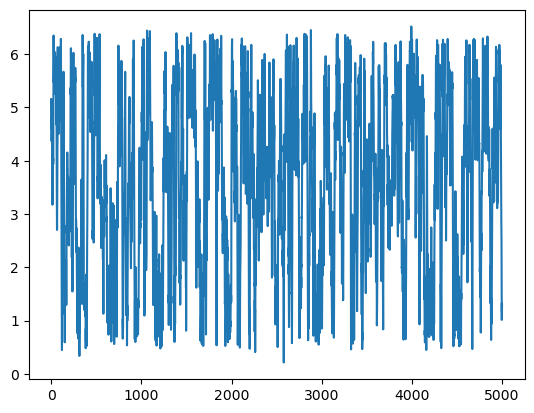

In [7]:
plt.figure()
plt.plot(all_coor[:,0])

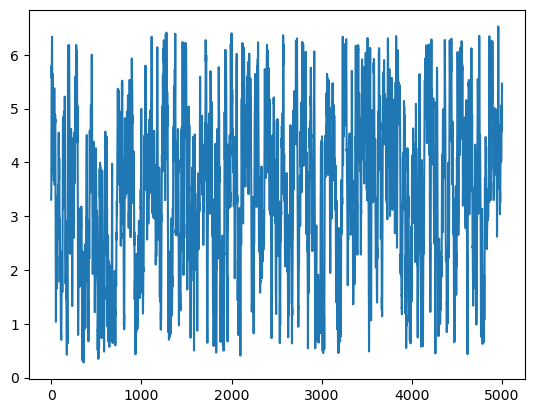

In [8]:
plt.figure()
plt.plot(all_coor[:,1])

In [36]:
all_coor

array([[ 4.80796480e+00,  4.06175613e+00,  2.81266379e-03,
        -6.92485273e-02,  1.21160798e-01, -8.15145895e-02],
       [ 4.91704559e+00,  3.96418953e+00, -5.06339334e-02,
        -1.89079091e-01, -9.12223943e-03,  9.45557281e-02],
       [ 4.86911535e+00,  4.23181200e+00, -7.35096410e-02,
         2.45535932e-02, -1.22009546e-01,  8.73768106e-02],
       ...,
       [ 3.48435640e+00,  4.68641472e+00,  4.29759212e-02,
         1.08208947e-01, -1.26247063e-01,  6.45658374e-02],
       [ 3.92420983e+00,  3.87450171e+00, -9.51055363e-02,
        -8.23898800e-03,  2.54791081e-02, -1.02998406e-01],
       [ 4.30523014e+00,  3.63896680e+00, -6.99204877e-02,
         1.38208732e-01, -8.00478607e-02,  5.17480485e-02]])

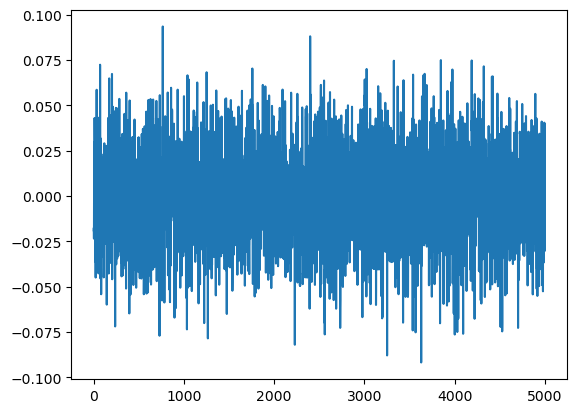

In [10]:
plt.figure()
plt.plot(all_coor[:,2])

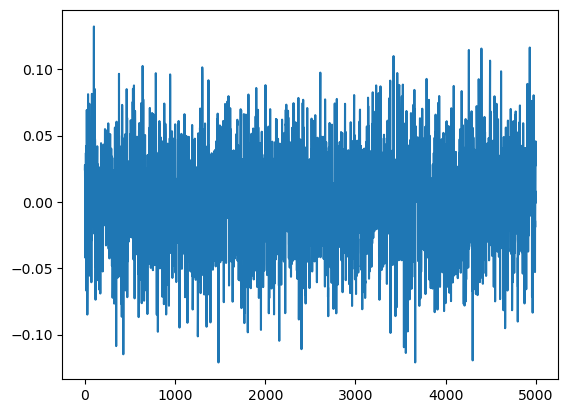

In [11]:
plt.figure()
plt.plot(all_coor[:,3])

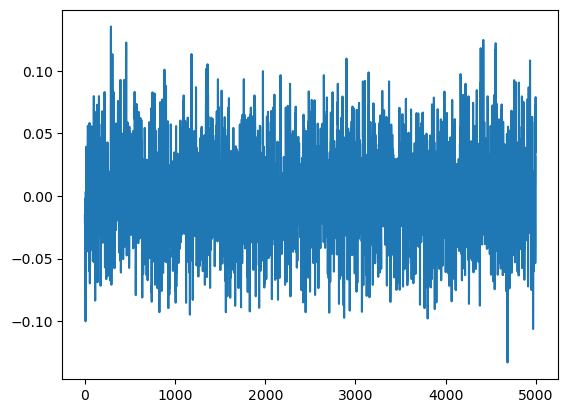

In [12]:
plt.figure()
plt.plot(all_coor[:,4])

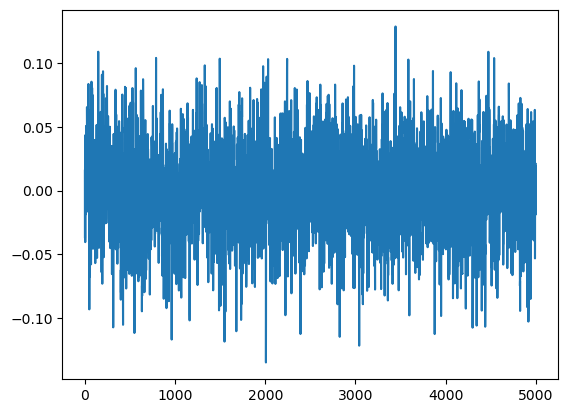

In [13]:
plt.figure()
plt.plot(all_coor[:,5])

When using only two principal components the data is split up into the significant and the insignificant data. To rectify this I will take 6 PCA components and see which two principal components are responsible for what amount of variance.

In [22]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [23]:
data = pd.DataFrame()
data['x1'] = all_coor[:,0]
data['y1'] = all_coor[:,1]
data['z1'] = all_coor[:,2]
data['x2'] = all_coor[:,3]
data['y2'] = all_coor[:,4]
data['z2'] = all_coor[:,5]

In [24]:
x = StandardScaler().fit_transform(all_coor)

In [42]:
pca = PCA(n_components=6)

In [43]:
#principal_components = pca.fit_transform(x)
principal_variance = pca.fit(x)

In [44]:
explained_variance = principal_variance.explained_variance_ratio_

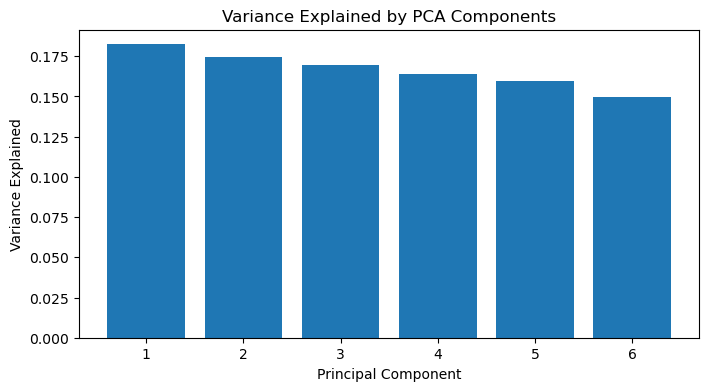

In [45]:
plt.figure(figsize=(8, 4))
plt.bar(range(1, len(explained_variance) + 1), explained_variance)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Variance Explained by PCA Components')
plt.show()

In [29]:
plt.figure()
plt.plot(principal_components[:,0])

NameError: name 'principal_components' is not defined

<Figure size 640x480 with 0 Axes>

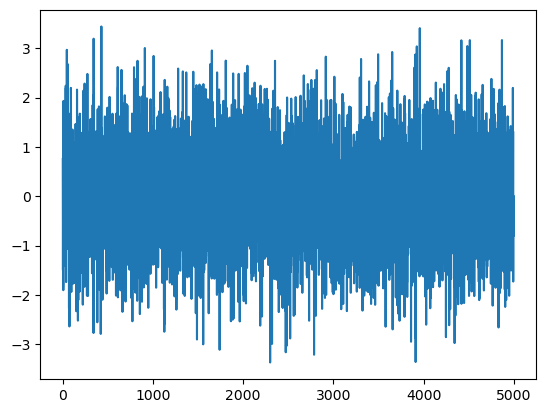

In [21]:
plt.figure()
plt.plot(principal_components[:,1])

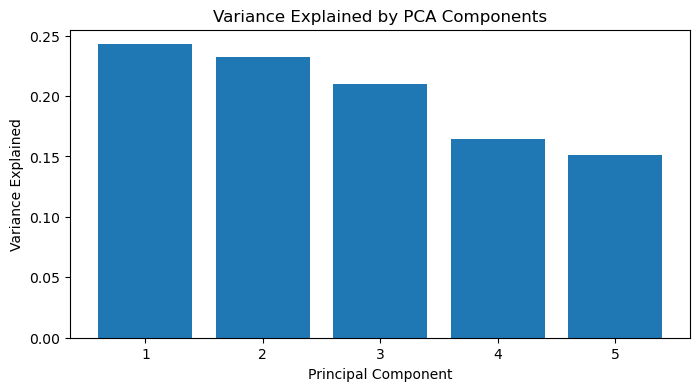

In [22]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Example data - replace this with your dataset
np.random.seed(0)
data = np.random.randn(100, 5)  # 100 samples with 5 features

# Perform PCA
pca = PCA(n_components=5)
pca.fit(data)

# Extract the explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Create a bar plot
plt.figure(figsize=(8, 4))
plt.bar(range(1, len(explained_variance) + 1), explained_variance)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Variance Explained by PCA Components')
plt.show()